# Statistical Tests Notebook

## TO DO:
- ~~LB: Esportare i T90 dei simulati su file di testo usando il  metodo della classe;~~
- ~~LB: Esportare gli errori delle curve di luce simulate (radice quadrata dei conteggi con il background);~~
- ~~AF: Rifare tutto solo con i long (rimuovere tutti i GRB con T90 < 2s);~~
- ~~AF: Tagliare i grb con `S/N del picco <10`;~~
- ~~AF: Sostituire il plot del T90 con quello del 20%;~~
- AF: Rebinnare la curva mediata -> rebinno bin fino a che il contenuto del bin ha un numero di conteggi > `n_sigma * bin_error`, con `n_sigma = 1`;
- ~~AF: Cambiare la tecnica con cui viene calcolato l'S/N dei grb (S/N del picco) con quella suggerita da Cristiano (S/N di tutto il GRB)~~ 
- ~~Autocorrelazione: in attesa di news;~~
- ~~LB: Rewrite everything inside functions and comment thoroughly the code!~~
- Chiedere ad Anastasia perchè nella funzione `_restore_lc()` manca il fattore `ampl` che aveva usato prima. Chiedere anche come salvare il file `yaml`;

### REFERENCES:
- [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267)
- [Mitrofanov et al., 1996](https://ui.adsabs.harvard.edu/abs/1996MmSAI..67..417M/abstract)
- [Link et al., 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter

import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
%config InlineBackend.figure_format='retina' # very useful command for high-res images
%matplotlib inline

SEED=42
np.random.seed(SEED)

In [2]:
# set the username for the path of the files:
#user='LB'
user='AF'

if user=='LB':
    file_path='/home/lorenzo/Desktop/Astrophysics/PYTHON/DATA/CGRO_BATSE/'
    sim_path ='/home/lorenzo/git/lc_pulse_avalanche/simulations/'
elif user=='AF':
    file_path='E:/grb_to_test/CGRO_BATSE/'
    sim_path ='E:/grb_to_test/simulations/'
else:
    raise ValueError('Assign to the variable "user" a correct username!')

In [3]:
class GRB:
    """
    Class for GRBs where to store their properties.
    """
    def __init__(self, grb_name, times, counts, errs, t90):
        self.name   = grb_name
        self.times  = times
        self.counts = counts
        self.errs   = errs
        self.t90    = t90

### T90 Calculation 
The 90% duration of the burst in seconds. T90 measures the duration of the time interval during which 90% of the total observed counts have been detected. The start of the T90 interval is defined by the time at which 5% of the total counts have been detected, and the end of the T90 interval is defined by the time at which 95% of the total counts have been detected (definition taken [here](https://heasarc.gsfc.nasa.gov/grbcat/notes.html)).

N.B.: For BATSE, all the T90s of the GRBs have been already evaluated by Cristiano. The file is uploaded on the repository for easier access here: `/astrodata/guidorzi/CGRO_BATSE/T90_full.dat`


In [4]:
# def evaluateT90(times, counts):
#     """
#     Compute the T90 of a GRB.
#     Inputs:
#       - times: time values of the bins of the light-curve;
#       - counts: counts per bin of the GRB;
#     Output:
#       - t90: T90 of the GRB
#     """
#     cumulative_counts = np.cumsum(counts)
#     total_counts = cumulative_counts[-1]
#     t_5_counts   = 0.05 * total_counts
#     t_95_counts  = 0.95 * total_counts
#     t_5_index    = np.where(cumulative_counts <=  t_5_counts )[0][-1]
#     t_95_index   = np.where(cumulative_counts >=  t_95_counts)[0][ 0]
#     t_5  = times[t_5_index]
#     t_95 = times[t_95_index]
#     t90  = t_95-t_5
#     assert t90>0
#     return t90

# LOAD DATA

### Load BASTE Data

In [4]:
# BATSE parameters

t_i=0          # [s]
t_f=150        # [s]
bin_time=0.064 # [s] temporal bins for BATSE
test_times=np.linspace(t_i, t_f, int((t_f-t_i)/bin_time))

In [5]:
def evaluateDuration20(times, counts, filter=False, t90=None, bin_time=None):
    """
    Compute the duration of the GRB event as described in [Stern et al., 1996].
    We define the starting time when the signal reaches the 20% of the value of
    the peak, and analogously for the ending time. The difference of those two
    times is taken as definition of the duration of the GRBs (T20%).
    If filter==True, then before computing the T20% we smooth the signal using
    a Savitzky-Golay filter on the light curves.
    Inputs:
      - times: time values of the bins of the light-curve;
      - counts: counts per bin of the GRB;
      - filter: boolean variable. Activate/deactivate the smoothing filter 
                before computing the T20% duration;
      - t90: T90 duration of the GRB;
      - bin_time: temporal bin size of BATSE [s];
    Output:
      - duration: T20%, that is, the duration at 20% level;
    """
    if filter:
        t90_frac = 5.
        window   = int(t90/t90_frac/bin_time)
        window   = window if window%2==1 else window+1
        counts   = savgol_filter(counts, window, 2)

    threshold_level = 0.2
    c_max           = np.max(counts)
    c_threshold     = c_max * threshold_level
    selected_times  = times[counts >= c_threshold]
    tstart          = selected_times[ 0]
    tstop           = selected_times[-1]
    duration        = tstop - tstart
    assert duration>0

    return np.array( [duration, tstart, tstop] )

In [7]:
def evaluateGRB_SN_ratio(times, counts, errs, t90, bin_time):
    """
    Compute the S/N ratio between the total signal from a GRB and the background
    in a time interval equal to the GRB duration, as defined in Stern+96, i.e.,
    the time interval between the first and the last moments in which the signal
    reaches the 20% of the peak (T20%). The S2N ratio is defined in the 
    following way: we sum of the signal inside the time window defined by the 
    T20%, and we divide it by the square root of the squared sum of the errors
    in the same time interval.
    Input:
     - t90: T90 of the GRB
     - times: array of times;
     - counts: counts of the event;
     - errs: errors over the counts;
    Output:
     - s2n: signal to noise ratio;
    """
    _, tstart, tstop = evaluateDuration20(times=times, 
                                          counts=counts, 
                                          filter=True, 
                                          t90=t90, 
                                          bin_time=bin_time)
    
    event_times_mask = np.logical_and(times>=tstart, times<=tstop)
    sum_grb_counts   = np.sum( counts[event_times_mask] )
    sum_errs         = np.sqrt( np.sum(errs[event_times_mask]**2) )
    s2n              = np.abs( sum_grb_counts/sum_errs )
    return s2n

In [8]:
ef load_lc_batse(path, sn_threshold=50, t90_threshold=2, bin_time=0.064):
    """
    Load the BATSE light curves, and put each of them in an object inside
    a list. Since in the analysis we consider only the long GRBs, we load 
    only the light curves listed in the 'alltrig_long.list' file. Then, we 
    take only the light curves satisfying the following constraints:
    - T90 > t90_threshold (2 sec);
    - GRB signal S2N > sn_threshold;
    - the measurement lasts at least for 150s after the peak;
    Input:
    - path: path to the folder that contains a file for each BATSE GRB and the
            file containing all the T90s;
    - sn_threshold;
    - t90_threshold;
    - bin_time: temporal bin size of BATSE [s];
    Output: 
    - grb_list_batse: list of objects, where each object is a GRB that satisfies
                      the constraints described above;
    """
    # load only the GRBs that are already classified as 'long'
    all_grb_list_batse = [grb_num.rstrip('\n') for grb_num in open(path + 'alltrig_long.list').readlines()]
    # load T90s
    t90data = np.loadtxt(path+'T90_full.dat')

    grb_list_batse = []
    for grb_name in all_grb_list_batse:
        t90     = t90data[t90data[:,0] == float(grb_name),1]
        times, counts, errs = np.loadtxt(path+grb_name+'_all_bs.out', unpack=True)
        i_c_max = np.argmax(counts)
        s_n     = evaluateGRB_SN_ratio(times=times, 
                                       counts=counts, 
                                       errs=errs, 
                                       t90=t90,
                                       bin_time=bin_time)
        cond_1 = t90>t90_threshold
        cond_2 = s_n>sn_threshold
        cond_3 = len(counts[i_c_max:])>=(150/bin_time)
        if ( cond_1 and cond_2 and cond_3 ):
            grb = GRB(grb_name, times, counts, errs, t90)
            grb_list_batse.append(grb)

    print("Total number of GRBs in catalogue: ", len(all_grb_list_batse))
    print("Selected GRBs: ", len(grb_list_batse))
    return grb_list_batse

In [9]:
# load the BATSE GRBs
grb_list_batse = load_lc_batse(path=file_path, 
                               bin_time=bin_time)

Total number of GRBs in catalogue:  1457
Selected GRBs:  758


### Load Simulated Data

Here we load the simulated GRBs produced with the avalanche; the files are: `lcXXX.txt`, one file for each simulated GRB.

In [14]:
def load_lc_sim(path, sn_threshold=10, t90_threshold=2):
    """
    Load the simulated light curves, and put each of them in an object inside
    a list. We take only the light curves satisfying the following constraints:
    - T90 > t90_threshold (2 sec);
    - GRB signal S2N > sn_threshold;
    Input:
    - path: path to the folder that contains a file for each simulated GRB;
    - sn_threshold;
    - t90_threshold;
    Output: 
    - grb_list_sim: list of objects, where each object is a GRB that satisfies
                    the constraints described above;
    """
    grb_sim_names = os.listdir(sim_path)
    grb_list_sim  = []
    for grb_file in grb_sim_names:
        grb_name = grb_file[grb_file.find('lc') + 2: grb_file.find('.txt')]
        times, counts, errs, t90 = np.loadtxt(sim_path + grb_file, unpack=True)
        s_n     = evaluateGRB_SN_ratio(times=times, 
                                       counts=counts, 
                                       errs=errs, 
                                       t90=t90[0],
                                       bin_time=bin_time)
        cond_1   = t90[0]>t90_threshold
        cond_2   = s_n>sn_threshold
        if ( cond_1 and cond_2 ):
            grb = GRB(grb_name, times, counts, errs, t90[0])
            grb_list_sim.append(grb) 
    return grb_list_sim

In [15]:
# load the simulated GRBs
grb_list_sim = load_lc_sim(path=sim_path)

# Test 1&2: Average Peak-Aligned Profiles

In [16]:
def compute_average_quantities(grb_list, t_f=150, bin_time=0.064):
    """
    Compute the averaged peak-aligned fluxes of the GRBs needed in the final
    plot. We follow the technique described in [Mitrofanov et al., 1996]. We 
    need only the signal _after_ the peak, which we extract and average over 
    all the light curves. Finally, we cut these averages at t_f = 150 sec (to
    reproduce the plot in [Stern et al., 1996] we need only the signal up to 
    150 sec after the peak).
    Input:
    - grb_list: list containing each GRB as an object;
    - t_f: range of time over which we compute the averaged fluxes;
    - bin_time: temporal bin size of BATSE [s];
    Output: 
    - averaged_fluxes: <F/F_p>;
    - averaged_fluxes_cube: <(F/F_p)^3>;
    - averaged_fluxes_rms : ( <(F/F_p)^2> - <F/F_p>^2 )^(1/2);
    """
    n_steps=int(t_f/bin_time)
    averaged_fluxes        = np.zeros(n_steps)
    averaged_fluxes_square = np.zeros(n_steps)
    averaged_fluxes_cube   = np.zeros(n_steps)

    for grb in grb_list:
        c_max         = np.max(grb.counts)
        i_c_max       = np.argmax(grb.counts)
        fluxes_to_sum = grb.counts[i_c_max:i_c_max+n_steps] / c_max
        assert np.isclose(fluxes_to_sum[0], 1, atol=1e-06), "ERROR: The peak is not aligned correctly..."

        averaged_fluxes        += fluxes_to_sum
        averaged_fluxes_square += fluxes_to_sum**2
        averaged_fluxes_cube   += fluxes_to_sum**3

    averaged_fluxes        /= len(grb_list)
    averaged_fluxes_square /= len(grb_list)
    averaged_fluxes_cube   /= len(grb_list)
    averaged_fluxes_rms     = np.sqrt(averaged_fluxes_square - averaged_fluxes**2)

    return averaged_fluxes, averaged_fluxes_cube, averaged_fluxes_rms

In [17]:
averaged_fluxes_batse, \
averaged_fluxes_cube_batse, \
averaged_fluxes_rms_batse = compute_average_quantities(grb_list=grb_list_batse, 
                                                       t_f=t_f, 
                                                       bin_time=bin_time)

averaged_fluxes_sim, \
averaged_fluxes_cube_sim, \
averaged_fluxes_rms_sim = compute_average_quantities(grb_list=grb_list_sim, 
                                                     t_f=t_f, 
                                                     bin_time=bin_time)

### Rebin function

In [18]:
def rebinFunction(x, y, erry, s_n_threshold=5, bin_reb_max=100):
    """
    Rebins the arrays x, y and erry (errors on the y) with the constraint that 
    all the bins of the rebinned vectors must have a S/N bigger than a given 
    threshold.
    Input:
      - x: x-array of the data
      - y: y-array of the data
      - erry: errors on the y
      - s_n_threshold: acceptance threshold on the S/N ratio.
      - bin_reb_max: maximum number of bins that can be rebinned together. We 
                     define a limit on the maximum number of bins which can be 
                     rebinned together to stop the algorithm from looping 
                     forever if we reach a region in which the background 
                     dominates the signal completely;
    Output:
      - reb_x: rebinned x-array
      - reb_y: rebinned y-array
      - reb_err: rebinned errors on the y
    """
    n_bins = 1
    reb_x, reb_y, reb_err = [], [], []
    for i in range(len(y)):
        new_x       = x[i]
        bin_sum     = y[i]
        err_bin_sum = erry[i]
        sn = bin_sum/err_bin_sum
        while(sn < s_n_threshold and n_bins <= bin_reb_max):
            n_bins += 1
            new_x       = np.mean(x[i:i+n_bins])
            bin_sum     = np.sum(y[i:i+n_bins])
            err_bin_sum = np.sqrt(np.sum(erry[i:i+n_bins])**2)
            sn = np.abs(bin_sum/err_bin_sum)
        reb_x.append(new_x)
        reb_y.append(bin_sum/n_bins)
        reb_err.append(err_bin_sum)
        i += n_bins
        n_bins = 1
    
    return np.array(reb_x), np.array(reb_y), np.array(reb_err)

In [19]:
# def roughRebin(vec, reb_factor, with_mean = True):
#     """
#     Rebins a vector of a given _constant_ factor.
#     Input:
#       - vec: vector to rebin
#       - reb_factor: rebin factor, i. e. the number of points to rebin together
#       - with_mean: boolean value. If true, the value of the points of the 
#                    rebinned vector are evaluated as the average of the points
#                    of the original vector that where to be rebinned together.  
#     Output:
#       - reb_vec: rebinned vector
#     """
#     if with_mean:
#         reb_vec = np.array( [np.mean(vec[i:i+reb_factor]) for i in np.arange(0,len(vec),reb_factor)] )
#     else:
#         reb_vec = np.array( [np.sum(vec[i:i+reb_factor])  for i in np.arange(0,len(vec),reb_factor)] )
#     return reb_vec

# Test 3: Autocorrelation

Following [Link et al., 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract), for a time lag $\tau$, the autocorrelation function is defined as

$$
    A(\tau)=\frac{\langle[s(t+\tau)-b][s(t)-b]\rangle_t}{\left\langle[s(t)-b]^2\right\rangle_t}
$$
where $s(t)$ is the intrinsic count rate due to the source (independent of photon counting statistics), $b$ is the background count rate, and $\langle\cdot\rangle_t$ denotes a time-average over the data interval. The measured count rate is $m(t)=s(t)+e(t)$, where $e(t)$ is the error. For a sufficiently long data set, the time average of $e$ vanishes; i.e., $\langle e(t)\rangle_t=0$. Assuming that the signal and noise are uncorrelated, i.e., $\langle s(t) e(t)\rangle_t=0$, we obtain
$$
\begin{aligned}
& A(\tau)=1 & (\tau=0) \\
& A(\tau)=\frac{\langle[m(t+\tau)-b][m(t)-b]\rangle_t}{\left\langle[m(t)-b]^2\right\rangle_t-\left\langle e(t)^2\right\rangle_t} & (\tau \neq 0) . \\
&
\end{aligned}
$$
For discretely sampled data in $N$ bins of equal size $\Delta t$, we express the autocorrelation function as a sum
$$
\begin{array}{rlr}
A(\tau) &= 1 & (\tau=0) \\
A(\tau) &= \frac{\sum_{i=1}^{N-u}\left(m_{i+u}-b\right)\left(m_i-b\right)}{\sum_{i=1}^N\left[\left(m_i-b\right)^2-e_i^2\right]} & (\tau \neq 0),
\end{array}
$$
where the lag is $\tau \equiv u \Delta t$.

In [20]:
def compute_autocorrelation(grb_list,  N_lim=1000, t_max=150, bin_time=0.064):
    """
    Compute the autocorrelation (ACF) of the GRBs. The ACF is computed up to
    a shift of of the light curve of t_max = 150 seconds. The autocorrelation
    is defined as in Link et al., 1993.
    Inputs:
    - grb_list: list of GRB objects;
    - N_lim: max number of GRBs with which we compute the ACF;
    - t_max: max shift of the autocorrelation;
    - bin_time: temporal bin size of BATSE [s];
    Outputs:
    - steps: time lag of the autocorrelation;
    - acf_link93: autocorrelation computed as in Link et al., 1993;
    """
    # Number of steps for ACF
    steps = np.arange(int(t_max/bin_time))

    # Evaluate ACF
    # acf_python = np.zeros_like(steps)
    acf_link93 = np.zeros_like(steps)
    for grb in grb_list[:N_lim]:
        counts = grb.counts
        errs   = grb.errs
        # AUTOCORRELATION: Link+93
        # errs=0
        acf_link93 = acf_link93 + [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        # AUTOCORRELATION: statsmodel
        # acf_python = acf_python + sm.tsa.acf(counts, nlags=len(steps)-1)
    acf_link93    /= N_lim
    acf_link93[0]  = 1

    return steps, acf_link93 #, acf_python

In [21]:
N_lim=np.min( [np.max(len(grb_list_sim  )), 
               np.max(len(grb_list_batse))] )
assert len(grb_list_sim)   >= N_lim
assert len(grb_list_batse) >= N_lim

steps_sim, acf_link93_sim     = compute_autocorrelation(grb_list=grb_list_sim,  
                                                        N_lim=N_lim, 
                                                        t_max=t_f, 
                                                        bin_time=bin_time)

steps_batse, acf_link93_batse = compute_autocorrelation(grb_list=grb_list_batse,  
                                                        N_lim=N_lim, 
                                                        t_max=t_f, 
                                                        bin_time=bin_time)

# Test 4: Duration
Duration of the GRB measured at a level of 20% of the peak, as in [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267). Before computing the duration, we filter the signal in order to smooth it.

In [22]:
duration_batse = [ evaluateDuration20(times=grb.times, 
                                      counts=grb.counts,
                                      filter=True,
                                      t90=grb.t90,
                                      bin_time=bin_time)[0] for grb in grb_list_batse ]

duration_sim   = [ evaluateDuration20(times=grb.times, 
                                      counts=grb.counts,
                                      filter=True,
                                      t90=grb.t90,
                                      bin_time=bin_time)[0] for grb in grb_list_sim   ]

log10_dur_batse = np.log10(duration_batse)
log10_dur_sim   = np.log10(duration_sim)

# PLOTS

/home/lorenzo/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10


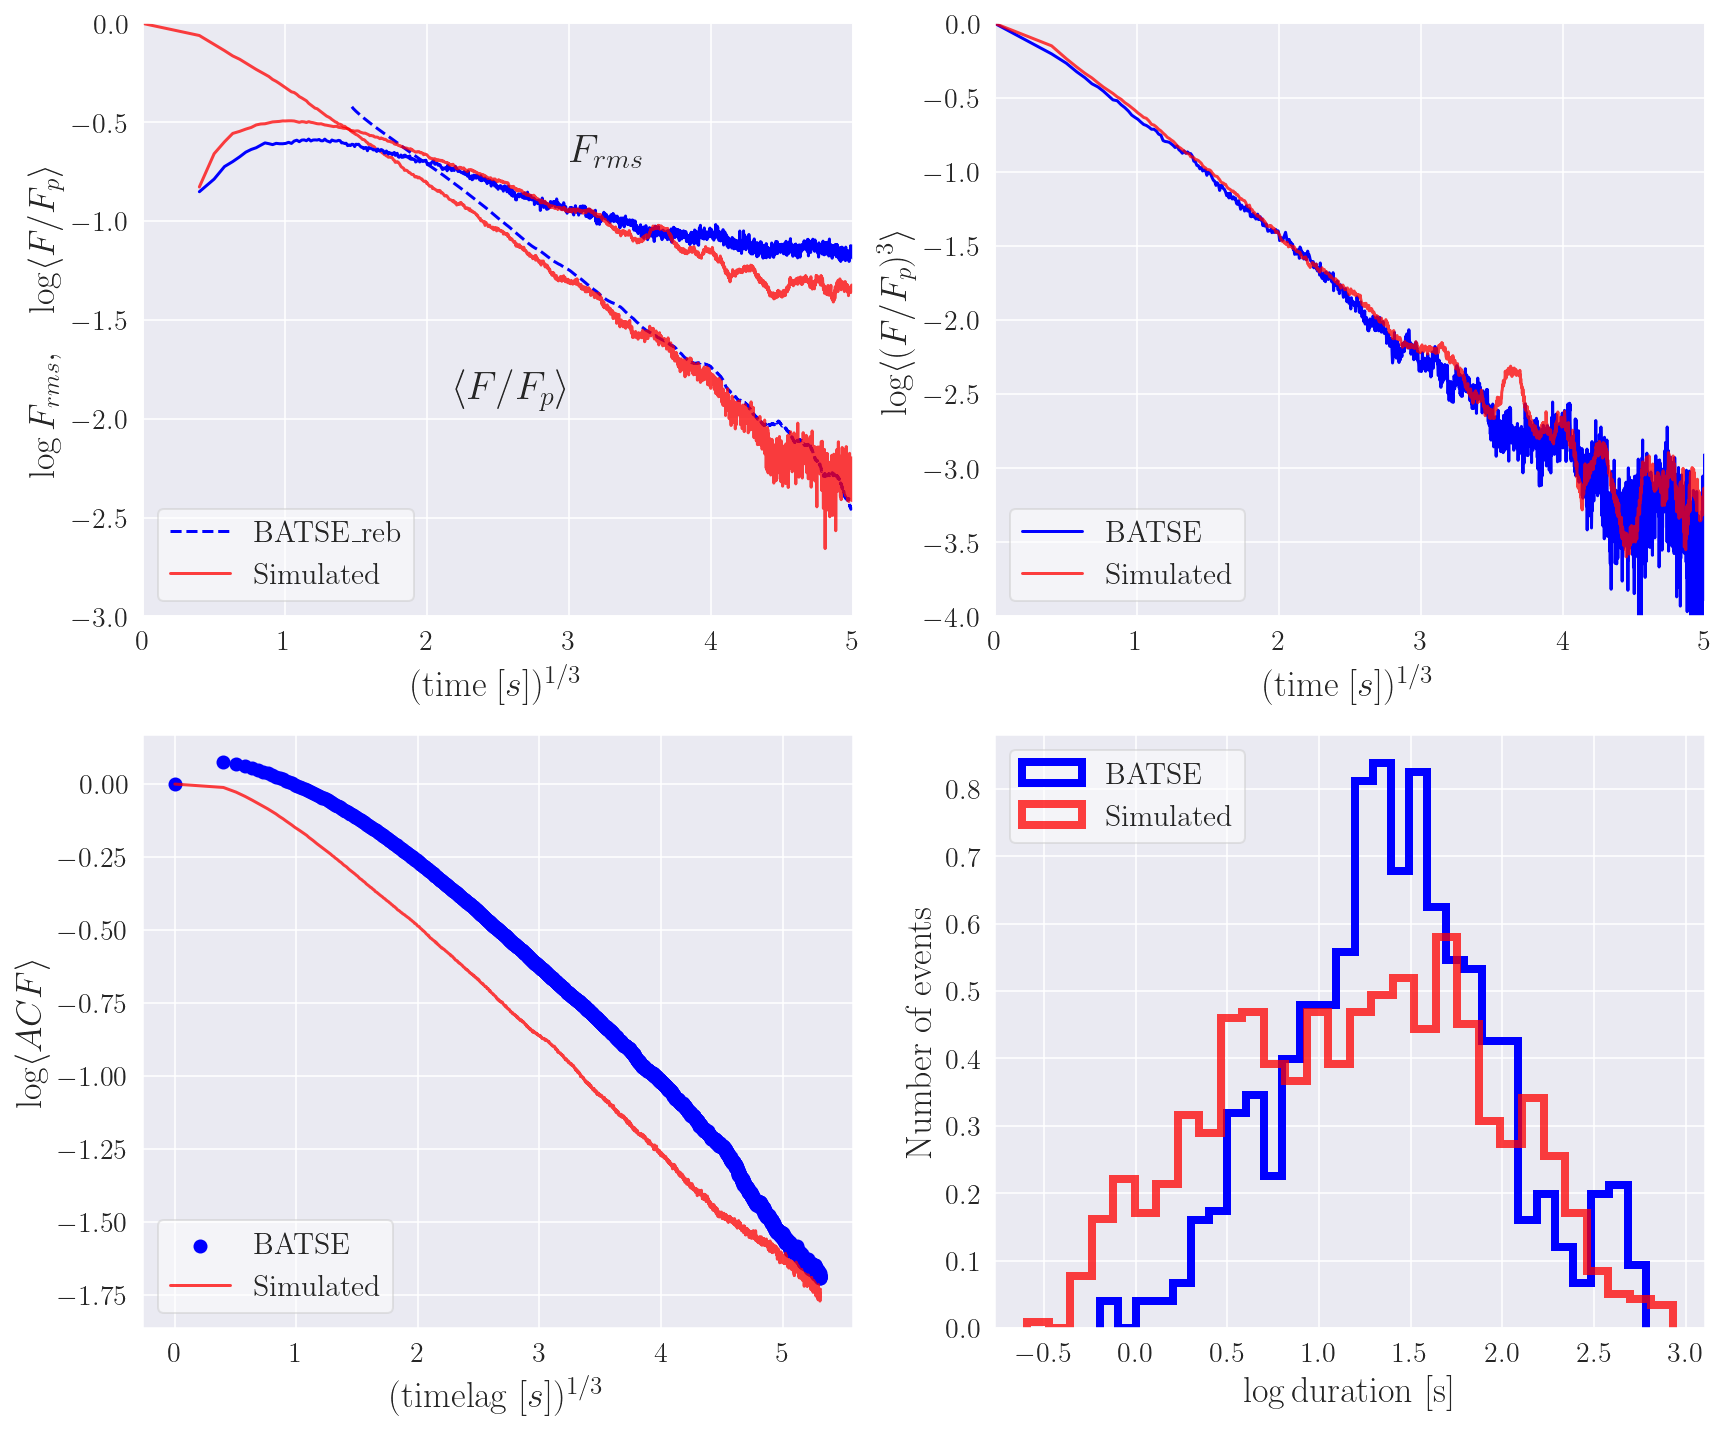

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(14,12))

#------------------------------------------------------------------------------#
# <F/F_p>
#------------------------------------------------------------------------------#

ax[0,0].set_axisbelow(True)
ax[0,0].set_xlabel(r'$(\mathrm{time}\ [s])^{1/3}$',                   size=18)
ax[0,0].set_ylabel(r'$\log F_{rms},\quad \log \langle F/F_p\rangle$', size=18)
#
#reb_times_batse, reb_data_batse = roughRebin(test_times, averaged_fluxes, 10)
reb_times_batse, reb_data_batse, _ = rebinFunction(test_times, averaged_fluxes_batse, 0.5*averaged_fluxes_batse, s_n_threshold=5)#I put an arbitrary value as error just to test if the function works
ax[0,0].plot(reb_times_batse**(1/3), np.log10(reb_data_batse),               color = 'b', alpha=1.00, label = r'BATSE_reb', ls='--', )
#ax[0,0].plot(test_times**(1/3),          np.log10(averaged_fluxes),         color = 'b', alpha=1.00, label = r'BATSE')
#
#reb_times_sim, reb_data_sim = roughRebin(simulated_times, simulated_fluxes, 10)
#ax[0,0].plot(reb_times_sim**(1/3),       np.log10(reb_data_sim),            color = 'r', alpha=0.75, label = r'Simulated_reb', ls='--', )
ax[0,0].plot(test_times**(1/3),     np.log10(averaged_fluxes_sim),           color = 'r', alpha=0.75, label = r'Simulated')
#
ax[0,0].plot(test_times[1:]**(1/3), np.log10(averaged_fluxes_rms_batse[1:]), color = 'b', alpha=1.00)
ax[0,0].plot(test_times[1:]**(1/3), np.log10(averaged_fluxes_rms_sim[1:]),   color = 'r', alpha=0.75)
#
ax[0,0].set_xlim(0,5)
ax[0,0].set_ylim(-3,0)
ax[0,0].text(3,   -0.7, r'$F_{rms}$',              fontsize=20)
ax[0,0].text(2.2, -1.9, r'$\langle F/F_p\rangle$', fontsize=20)
ax[0,0].xaxis.set_tick_params(labelsize=14)
ax[0,0].yaxis.set_tick_params(labelsize=14)
ax[0,0].legend(prop={'size':15}, loc="lower left", facecolor='white', framealpha=0.5)

#------------------------------------------------------------------------------#
# <(F/F_p)^3>
#------------------------------------------------------------------------------#

ax[0,1].set_axisbelow(True)
ax[0,1].set_xlabel(r'$(\mathrm{time}\ [s])^{1/3}$',     size=18)
ax[0,1].set_ylabel(r'$\log \langle (F/F_p)^3 \rangle$', size=18)
ax[0,1].plot(test_times**(1/3), np.log10(averaged_fluxes_cube_batse), color='b', label='BATSE')
ax[0,1].plot(test_times**(1/3), np.log10(averaged_fluxes_cube_sim),   color='r', label='Simulated', alpha=0.75)
ax[0,1].set_xlim(0,5)
ax[0,1].set_ylim(-4,0)
ax[0,1].xaxis.set_tick_params(labelsize=14)
ax[0,1].yaxis.set_tick_params(labelsize=14)
ax[0,1].legend(prop={'size':15}, loc="lower left", facecolor='white', framealpha=0.5)

#------------------------------------------------------------------------------#
# AUTOCORRELATION
#------------------------------------------------------------------------------#

#ax[1,0].scatter((steps*bin_time)**(1/3), (acf_link93),     color='b', label='BATSE')
#ax[1,0].plot((steps*bin_time)**(1/3), (sim_acf_link93), color='r', label='Simulated', alpha=0.75)
ax[1,0].scatter((steps_batse*bin_time)**(1/3), np.log10(acf_link93_batse), color='b', label='BATSE')
ax[1,0].plot((steps_sim*bin_time)**(1/3),      np.log10(acf_link93_sim),   color='r', label='Simulated', alpha=0.75)
ax[1,0].set_xlabel(r'$(\mathrm{timelag}\ [s])^{1/3}$', size=18)
ax[1,0].set_ylabel(r'$\log \langle ACF \rangle$',      size=18)
#ax[1,0].set_xlim(0,5)
#ax[1,0].set_ylim(-2,0.2)
ax[1,0].xaxis.set_tick_params(labelsize=14)
ax[1,0].yaxis.set_tick_params(labelsize=14)
ax[1,0].legend(prop={'size':15}, loc="lower left", facecolor='white', framealpha=0.5)

#------------------------------------------------------------------------------#
# HISTOGAM OF DURATIONS
#------------------------------------------------------------------------------#

ax[1,1].set_axisbelow(True)
ax[1,1].set_ylabel('Number of events', size=18)
ax[1,1].set_xlabel(r'$\log\mathrm{duration}$ [s]', size=18)

n_bins=30
n, bins, patches = ax[1,1].hist(x=log10_dur_batse, 
                                bins=n_bins,
                                alpha=1.00,
                                label='BATSE', 
                                color='b',
                                histtype='step',
                                linewidth=4,
                                density=True)

n, bins, patches = ax[1,1].hist(x=log10_dur_sim, 
                                bins=n_bins,
                                alpha=0.75,
                                label='Simulated', 
                                color='r',
                                histtype='step',
                                linewidth=4,
                                density=True)
                         
#ax[1,1].set_xlim(-2,3)
#ax[1,1].set_ylim(0,30)
ax[1,1].xaxis.set_tick_params(labelsize=14)
ax[1,1].yaxis.set_tick_params(labelsize=14)
ax[1,1].legend(prop={'size':15}, loc="upper left", facecolor='white', framealpha=0.5)

#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#

plt.show()

# DEBUG

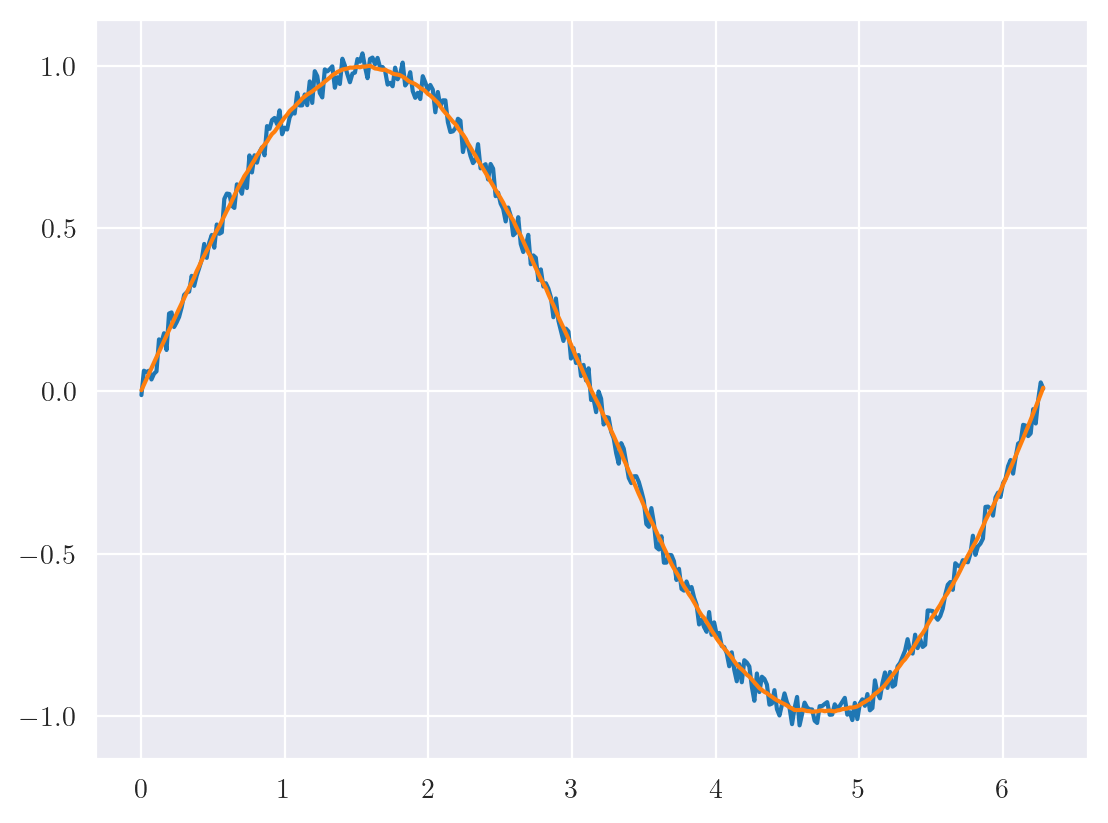

In [49]:
#Savitzky-Golay filter test
from scipy.signal import savgol_filter

times = np.linspace(0,2*np.pi, 360)
vals = (np.sin(times) + (np.random.rand(len(times))-0.5)*0.1) 

filtered_vals = savgol_filter(vals, 41, 2,0)
plt.plot(times, vals)
plt.plot(times, filtered_vals)

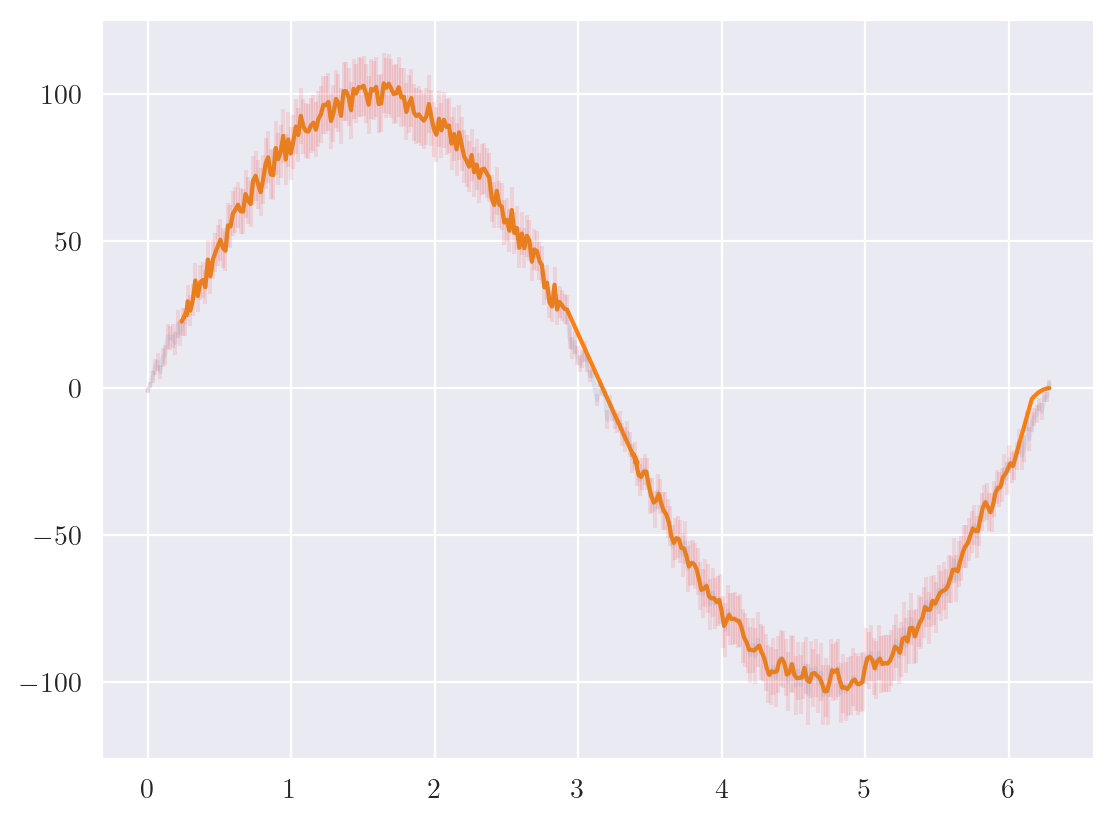

In [116]:
#Rebin test

times = np.linspace(0,2*np.pi, 360)
vals = ((np.sin(times) + (np.random.rand(len(times))-0.5)*0.1))*100 
errs = np.sqrt(np.abs(vals))

plt.errorbar(times, vals, yerr = errs, ecolor = 'red', alpha = 0.1)
reb_time, reb_vals, reb_errs = rebinFunction(times, vals, errs, s_n_threshold = 5)
#plt.errorbar(reb_time, reb_vals, yerr = reb_errs, ecolor = 'green', alpha = 0.5)
plt.plot(reb_time, reb_vals)

(100.0, 150.0)

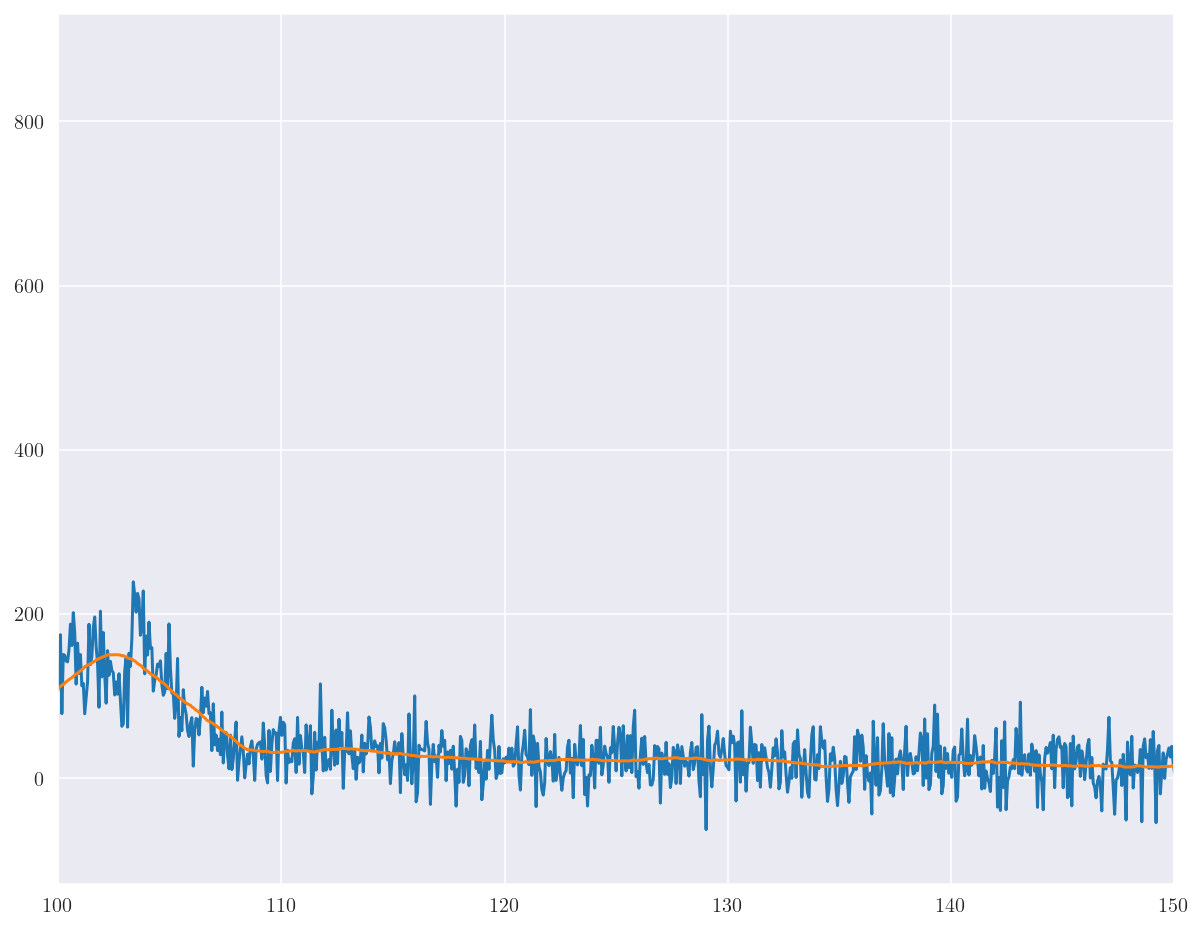

In [29]:
times = grb_list_batse[0].times
vals = grb_list_batse[0].counts

filtered_vals = savgol_filter(vals, 161, 2 , 0)
plt.figure(figsize=(10,8))
plt.plot(times, vals)
plt.plot(times, filtered_vals)
plt.xlim(100,150)
#plt.xlim(-50,350)

In [50]:
mean_value=0
for i, grb in enumerate(grb_list_batse[500:1000]):
    times=grb.times
    counts=grb.counts
    errs=grb.errs
    #plt.errorbar(times[::100], 
    #             counts[::100], 
    #             yerr=errs[::100],
    #             ecolor='r', 
    #             marker='.',
    #             color='b')
    #plt.show()    
    acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
    mean_value+=acf_link93_test[1]
    if(acf_link93_test[1]<-50):
        print(acf_link93_test[1], i)
    #print(acf_link93[1], i)
print('mean = ', mean_value/100)

mean =  2.0696508239636997


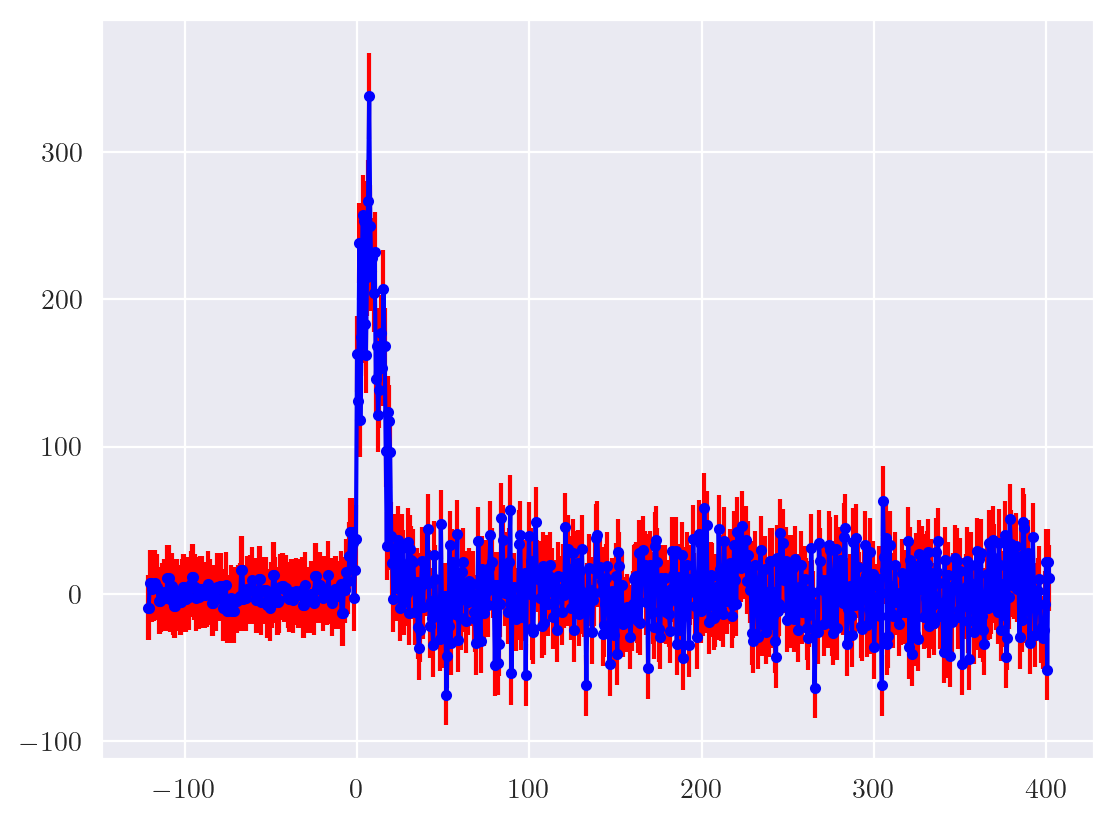

1.100963409212773 164


In [51]:
for i, grb in enumerate(grb_list_batse[:1000]):
    if i==164: # 187
        times=grb.times
        counts=grb.counts
        errs=grb.errs
        plt.errorbar(times[::10], 
                     counts[::10], 
                     yerr=errs[::10],
                     ecolor='r', 
                     marker='.',
                     color='b')
        plt.show()    
        acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        print(acf_link93_test[1], i)
    else:
        pass

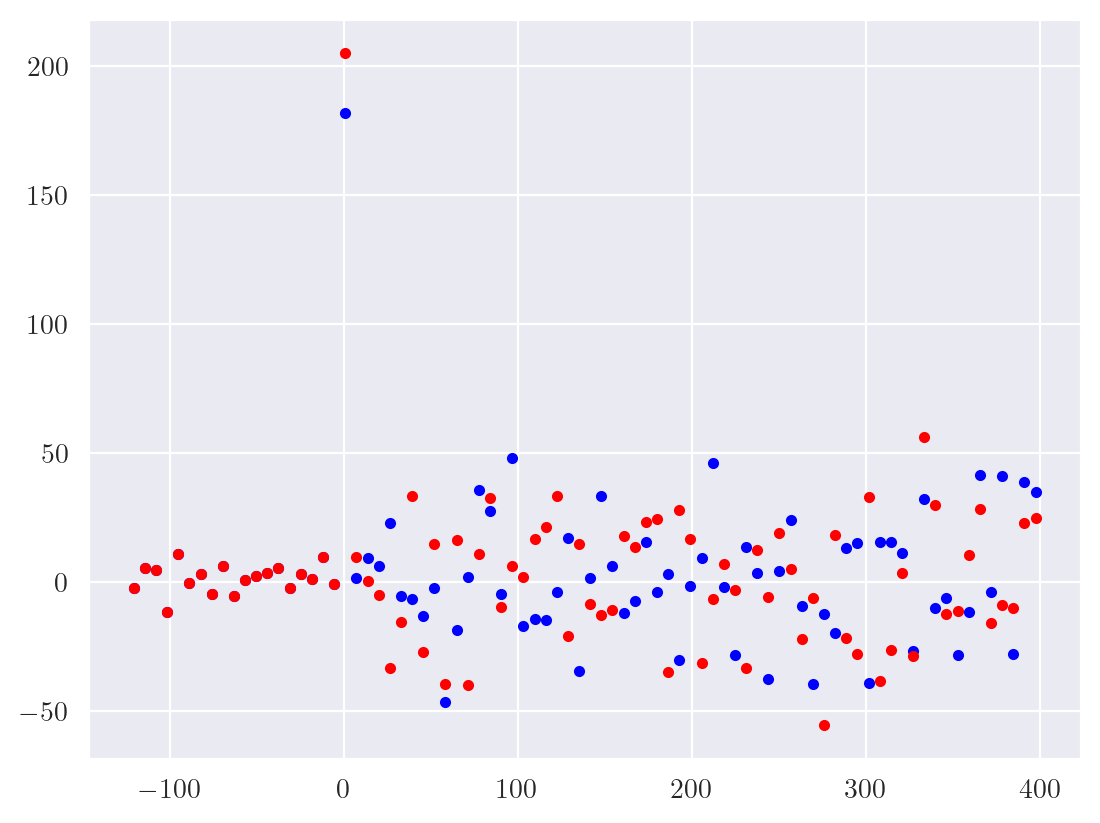

40.32327260478941 187


In [52]:
for i, grb in enumerate(grb_list_batse[:1000]):
    if i==187:
        times=grb.times
        counts=grb.counts
        errs=grb.errs
        counts_u1=np.roll(counts,-1)
        plt.scatter(times[::100], 
                    counts[::100], 
                    color='b',
                    marker='.')
        plt.scatter(times[::100], 
                    counts_u1[::100], 
                    color='r',
                    marker='.')
        plt.show()    
        acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        print(acf_link93_test[1], i)
    else:
        pass

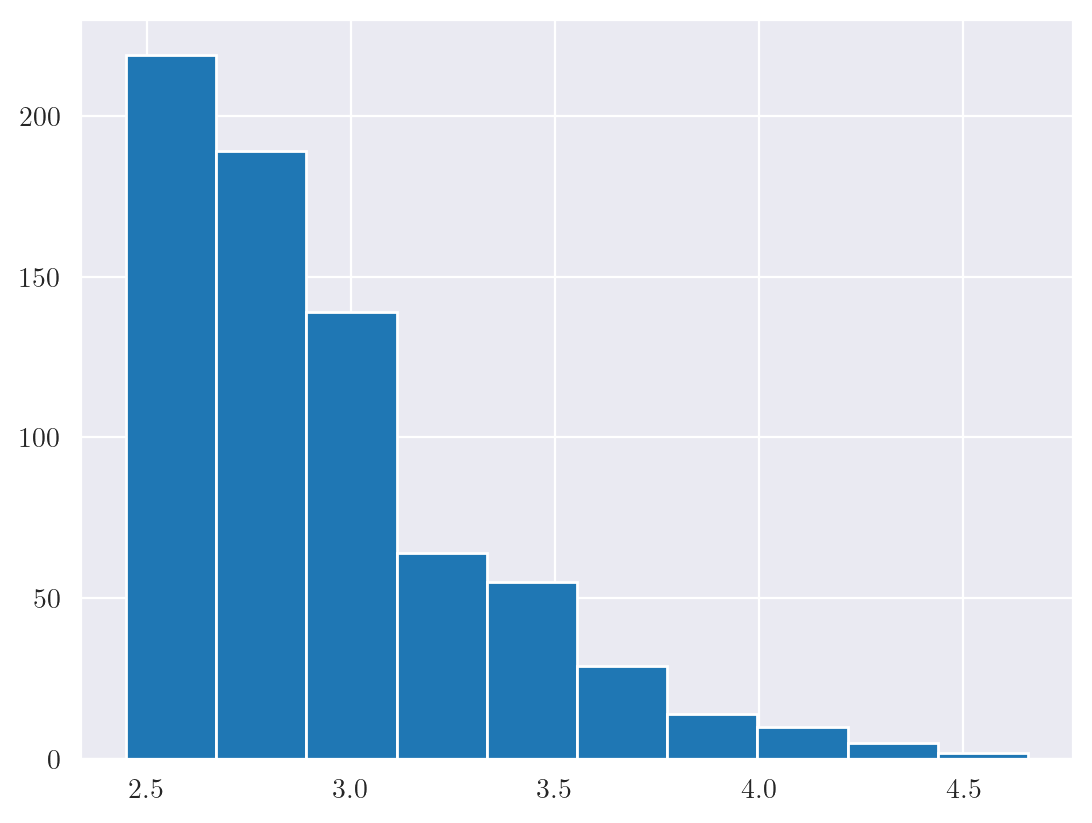

In [53]:
maxlist =[]
for i, grb in enumerate(grb_list_batse):
    maxlist.append(np.max(grb.counts))

plt.hist(np.log10(maxlist));